# Autoencodery

In [1]:
import numpy as np
from keras.datasets import mnist
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

from warnings import filterwarnings

filterwarnings('ignore')

2025-05-26 18:39:01.560006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 18:39:02.578501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Redukcja wymiarowości z wykorzystaniem PCA

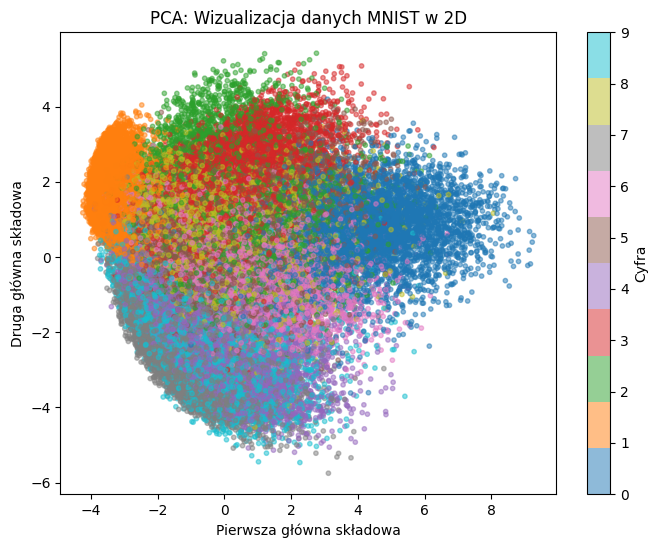

In [14]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype(np.float16) / 255
X_train_faltten = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))

X_test = X_test.astype(np.float16) / 255
X_test_flaten = X_test.reshape(X_test.shape[0], -1)

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_faltten)

plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, cmap='tab10', s=10, alpha=0.5)

plt.colorbar(scatter, label='Cyfra')
plt.title('PCA: Wizualizacja danych MNIST w 2D')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')

plt.show()


### Definowanie modelu autoenkodera

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

class DimansionRecuser(tf.keras.Model):
    def __init__(self, encoder = False):
        super().__init__()  

        self.encoder = encoder

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(50, activation='tanh')
        self.dense2 = layers.Dense(50, activation='tanh')
        self.latent = layers.Dense(2, activation='linear')
        self.dense3 = layers.Dense(50, activation='tanh')
        self.dense4 = layers.Dense(50, activation='tanh')
        self.dense5 = layers.Dense(28*28, activation='sigmoid')
        self.reshape = layers.Reshape(target_shape=(28, 28, 1))

    def call(self, inputs, training=False):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        mid = self.latent(x)

        x = self.dense3(mid)
        x = self.dense4(x)
        x = self.dense5(x)

        if self.encoder == True:
            return mid
        else:
            return self.reshape(x)

model = DimansionRecuser()

model.compile(
    loss=losses.MeanSquaredError(),
    optimizer=optimizers.Adam()
)

2025-05-26 18:39:09.436958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-26 18:39:09.645777: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Trening modelu

In [7]:
BATCH_SIZE = 128
EPOCHS = 50

model.fit(
    X_train,
    X_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split=0.2
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - val_loss: 0.0400
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - val_loss: 0.0399
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - val_loss: 0.0399
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.0400
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - val_loss: 0.0399
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.0400
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.0399
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.0398
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0392 - val_loss: 0.0398
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.0398
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0391 - val_loss: 0.0397
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


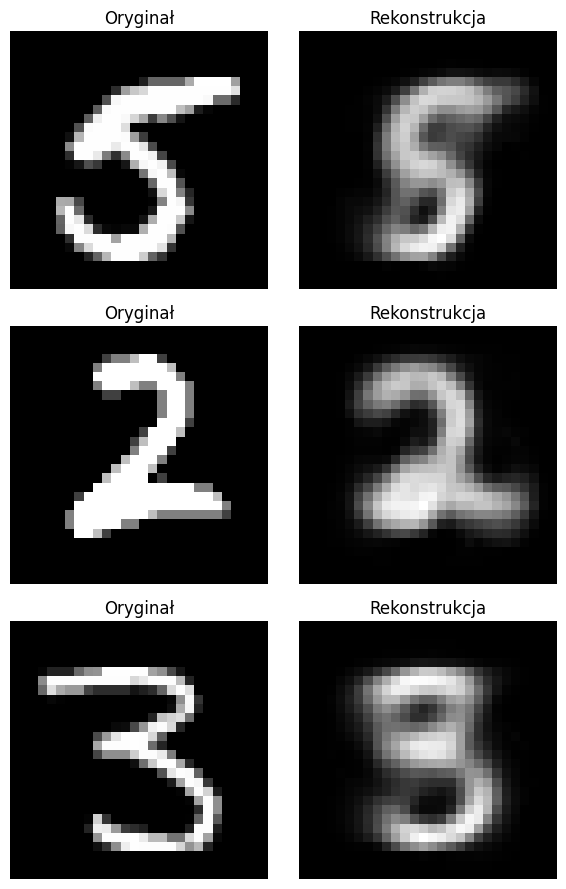

In [5]:
import random
import matplotlib.pyplot as plt

X_gen = model.predict(X_test)

rows = 3
cols = 2  

fig, axs = plt.subplots(rows, cols, figsize=(6, 9))

for row in range(rows):
    rand_int = random.randint(0, len(X_test) - 1)

    axs[row, 0].imshow(X_test[rand_int].squeeze(), cmap='gray')
    axs[row, 0].set_title("Oryginał")
    axs[row, 0].axis('off')

    axs[row, 1].imshow(X_gen[rand_int].squeeze(), cmap='gray')
    axs[row, 1].set_title("Rekonstrukcja")
    axs[row, 1].axis('off')

plt.tight_layout()
plt.show()


### Zapytać o co chodzi

In [ ]:
encoder = DimansionRecuser()

encoder.set_weights(model.get_weights())

X_latent = encoder.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=Y_test, cmap='tab10', s=5, alpha=0.7)
plt.colorbar()
plt.title("Reprezentacja latentna (2D) danych MNIST")
plt.xlabel("Zmienna 1")
plt.ylabel("Zmienna 2")
plt.grid(True)
plt.show()

### Podejście na około

In [ ]:
input_shape = (28, 28, 1)
 
inputs = layers.Input(shape=input_shape)
 
flatten = layers.Flatten()(inputs)
dense1 = layers.Dense(50, activation='tanh')(flatten)
dense2 = layers.Dense(50, activation='tanh')(dense1)
latent = layers.Dense(2, activation='linear')(dense2)
dense3 = layers.Dense(50, activation='tanh')(latent)
dense4 = layers.Dense(50, activation='tanh')(dense3)
dense5 = layers.Dense(28 * 28, activation='relu')(dense4)
outputs = layers.Reshape(target_shape=(28, 28, 1))(dense5)

model = keras.Model(inputs=inputs, outputs=outputs)
 
model.compile(loss=losses.MeanSquaredError, optimizer="adam")

### Trening

In [12]:
BATCH_SIZE = 128
EPOCHS = 50

model.fit(
    X_train,
    X_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split=0.2
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0709 - val_loss: 0.0552
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0544 - val_loss: 0.0511
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0506 - val_loss: 0.0481
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0478 - val_loss: 0.0460
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0461 - val_loss: 0.0449
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0451 - val_loss: 0.0444
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0444 - val_loss: 0.0438
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0438 - val_loss: 0.0434
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0435 - val_loss: 0.0431
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0431 - val_loss: 0.0427
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0427 - val_loss: 0.0425
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


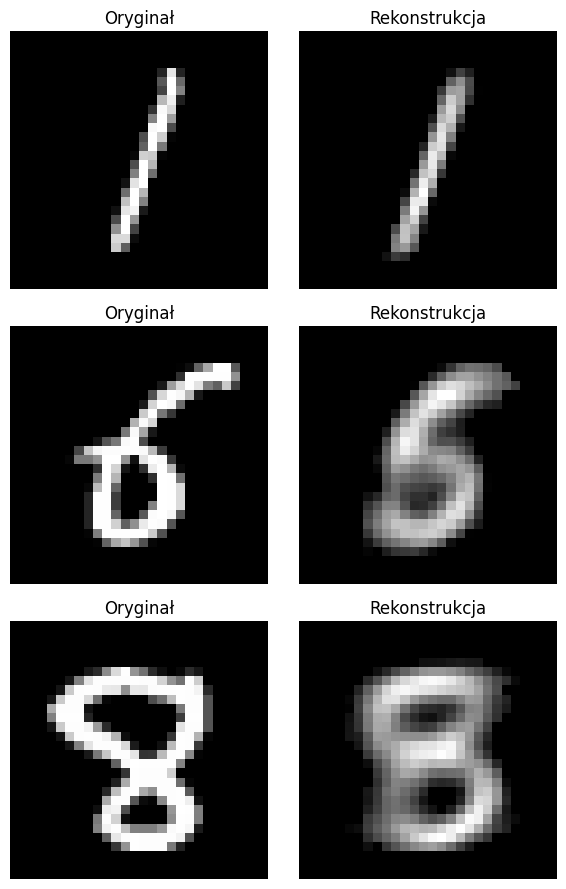

In [46]:
X_gen = model.predict(X_test)

rows = 3
cols = 2  

fig, axs = plt.subplots(rows, cols, figsize=(6, 9))

for row in range(rows):
    rand_int = random.randint(0, len(X_test) - 1)

    axs[row, 0].imshow(X_test[rand_int].squeeze(), cmap='gray')
    axs[row, 0].set_title("Oryginał")
    axs[row, 0].axis('off')

    axs[row, 1].imshow(X_gen[rand_int].squeeze(), cmap='gray')
    axs[row, 1].set_title("Rekonstrukcja")
    axs[row, 1].axis('off')

plt.tight_layout()
plt.show()


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


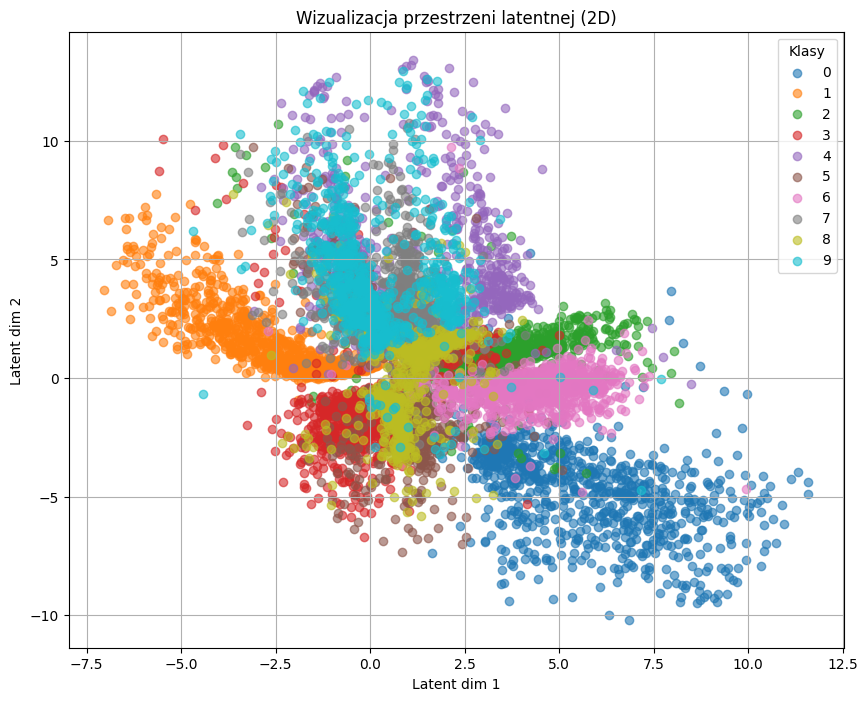

In [44]:
compression_model = keras.Model(inputs=inputs, outputs=latent)

X_test_subset, _, Y_test_subset, _ = train_test_split(X_test, Y_test, test_size=0.1, random_state=42)
X_compres = compression_model.predict(X_test_subset)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    X_tmp = X_compres[Y_test_subset == i]
    plt.scatter(X_tmp[:, 0], X_tmp[:, 1], label=str(i), alpha=0.6, color=colors[i])

plt.legend(title="Klasy")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Wizualizacja przestrzeni latentnej (2D)")
plt.grid(True)
plt.show()

In [43]:
Y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [42]:
Y_test_subset

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.